# Project 1

Alice Ding, Shoshana Farber, Christian Uriostegui

The goal of this project is to:

1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate _degree centrality_ and _eigenvector centrality_.
3. Compare your centrality measures across your categorical groups.

The dataset we are using for this project is the same [Marvel Comic Dataset](https://www.kaggle.com/datasets/trnguyen1510/the-marvel-comic-characters-partnerships?select=nodes.csv) from the [Week 2 - Part 2](https://github.com/ShanaFarber/cuny-data620/blob/main/week2_part2/Week2_Part2.ipynb) assignment. The datasets can be found in the [GitHub folder Week 2 - Part 2](https://github.com/ShanaFarber/cuny-data620/tree/main/week2_part2) assignment. 

This dataset contains all the characters and their partnerships in the Marvel Comic Univserse. From the description of the data on Kaggle, the dataset seems to include only partnerships for the year 2018. 

***

### Loading the Data

The data is loaded from GitHub using **Pandas** library.

In [30]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

nodes = pd.read_csv('https://raw.githubusercontent.com/ShanaFarber/cuny-data620/main/week2_part2/nodes.csv')
edges = pd.read_csv('https://raw.githubusercontent.com/ShanaFarber/cuny-data620/main/week2_part2/edges.csv')

Let's preview the data. 

In [31]:
# nodes data

pd.DataFrame(nodes.head(10))

,group,id,size
0,1,Baron Zemo,2
1,1,N'astirh,3
2,0,Silver Sable,1
3,0,Hope Summers (comics),1
4,0,Magik (Illyana Rasputin),1
5,0,Night Thrasher (Dwayne Taylor),2
6,1,Orb (comics),1
7,0,Forge (comics),1
8,0,U.S. Agent (character),1
9,1,Venom (Marvel Comics character),6


**nodes** has three columns:
- `group` - the category which the comic book character fall into (0 - hero; 1 - villain; 2 - antihero)
- `id` - the unique name of the comic book character
- `size` - the number of connections the comic book character has to other comic book characters

In [32]:
# edges data

pd.DataFrame(edges.head(10))

,source,target
0,Baron Zemo,Blackout (Marcus Daniels)
1,Baron Zemo,Vermin (comics)
2,N'astirh,S'ym
3,N'astirh,Belasco (Marvel Comics)
4,N'astirh,Madelyne Pryor
5,Silver Sable,Peregrine (comics)
6,Hope Summers (comics),Cable (comics)
7,Magik (Illyana Rasputin),Belasco (Marvel Comics)
8,Night Thrasher (Dwayne Taylor),Midnight's Fire
9,Night Thrasher (Dwayne Taylor),Silhouette (comics)


**edges** has two columns:
- `source` - a chosen character (node)
- `target` - other characters (nodes) that character is connected to

***

### Exploratory Analysis

**How many characters fall into each category?**

In [33]:
pd.DataFrame(nodes).groupby('group').count()

,id,size
group,,
0,121,121
1,194,194
2,35,35


There are 121 heroes, 194 villains, and 35 antiheroes in this dataset. 

***

**What is the largest number of connections? Who has the most connections?**

In [34]:
pd.DataFrame(nodes).sort_values('size', ascending=False).head()

,group,id,size
193,0,Spider-Man,12
301,0,Captain America,10
305,1,Red Skull,9
238,1,Attuma,8
219,1,Unicorn (comics),8


Spider-Man has the most connections, being associated with 12 other characters.

We can also see from the top five connections that 2/5 are heroes while 3/5 are villains. 

***

**Are there any characters with no connections?**

In [35]:
pd.DataFrame(nodes).sort_values('size').head(1)

,group,id,size
174,1,Mentallo,1


Every character has at least 1 connection.

***

### Some Cleaning

While some characters have a parenthesis with their real names, others have "Marvel Comics", "comics", "character", or "Marvel Comics character" in parenthesis after their alias. For visualization purposes so there are not as many words on the screen per each node, let's remove these parenthesis. 

In [36]:
nodes['id'] = nodes['id'].str.replace('\s\(comics\)|\s\(Marvel Comics\)|\s\(Marvel Comics character\)|\s\(character\)', '', regex=True)

edges['source'] = edges['source'].str.replace('\s\(comics\)|\s\(Marvel Comics\)|\s\(Marvel Comics character\)|\s\(character\)', '', regex=True)
edges['target'] = edges['target'].str.replace('\s\(comics\)|\s\(Marvel Comics\)|\s\(Marvel Comics character\)|\s\(character\)', '', regex=True)

In [37]:
pd.DataFrame(nodes.head(5))

,group,id,size
0,1,Baron Zemo,2
1,1,N'astirh,3
2,0,Silver Sable,1
3,0,Hope Summers,1
4,0,Magik (Illyana Rasputin),1
5,0,Night Thrasher (Dwayne Taylor),2
6,1,Orb,1
7,0,Forge,1
8,0,U.S. Agent,1
9,1,Venom,6


In [38]:
pd.DataFrame(edges.head(5))

,source,target
0,Baron Zemo,Blackout (Marcus Daniels)
1,Baron Zemo,Vermin
2,N'astirh,S'ym
3,N'astirh,Belasco
4,N'astirh,Madelyne Pryor
5,Silver Sable,Peregrine
6,Hope Summers,Cable
7,Magik (Illyana Rasputin),Belasco
8,Night Thrasher (Dwayne Taylor),Midnight's Fire
9,Night Thrasher (Dwayne Taylor),Silhouette


Now we only have parenthesis for those with a name in parenthesis. 

Iron Man has a parenthesis with "Ultimate Marvel character" in it in one place. I don't believe that this is a seceond Iron Man, as a quick Google search names "Iron Man (Ultimate Marvel character)" as being Tony Stark. For this reason, I chose to also remove this parenthesis. The result is that Iron Man appears as a node twice, so I had to make the nodes unique. 

In [39]:
nodes['id'] = nodes['id'].str.replace('\s\(Ultimate Marvel character\)', '', regex=True)

edges['source'] = edges['source'].str.replace('\s\(Ultimate Marvel character\)', '', regex=True)
edges['target'] = edges['target'].str.replace('\s\(Ultimate Marvel character\)', '', regex=True)

In [40]:
nodes_new = nodes[['group', 'id']]

nodes_new = nodes_new.drop_duplicates()

### Creating the Network

Let's add the nodes and edges to the network using **NetworkX** library. 

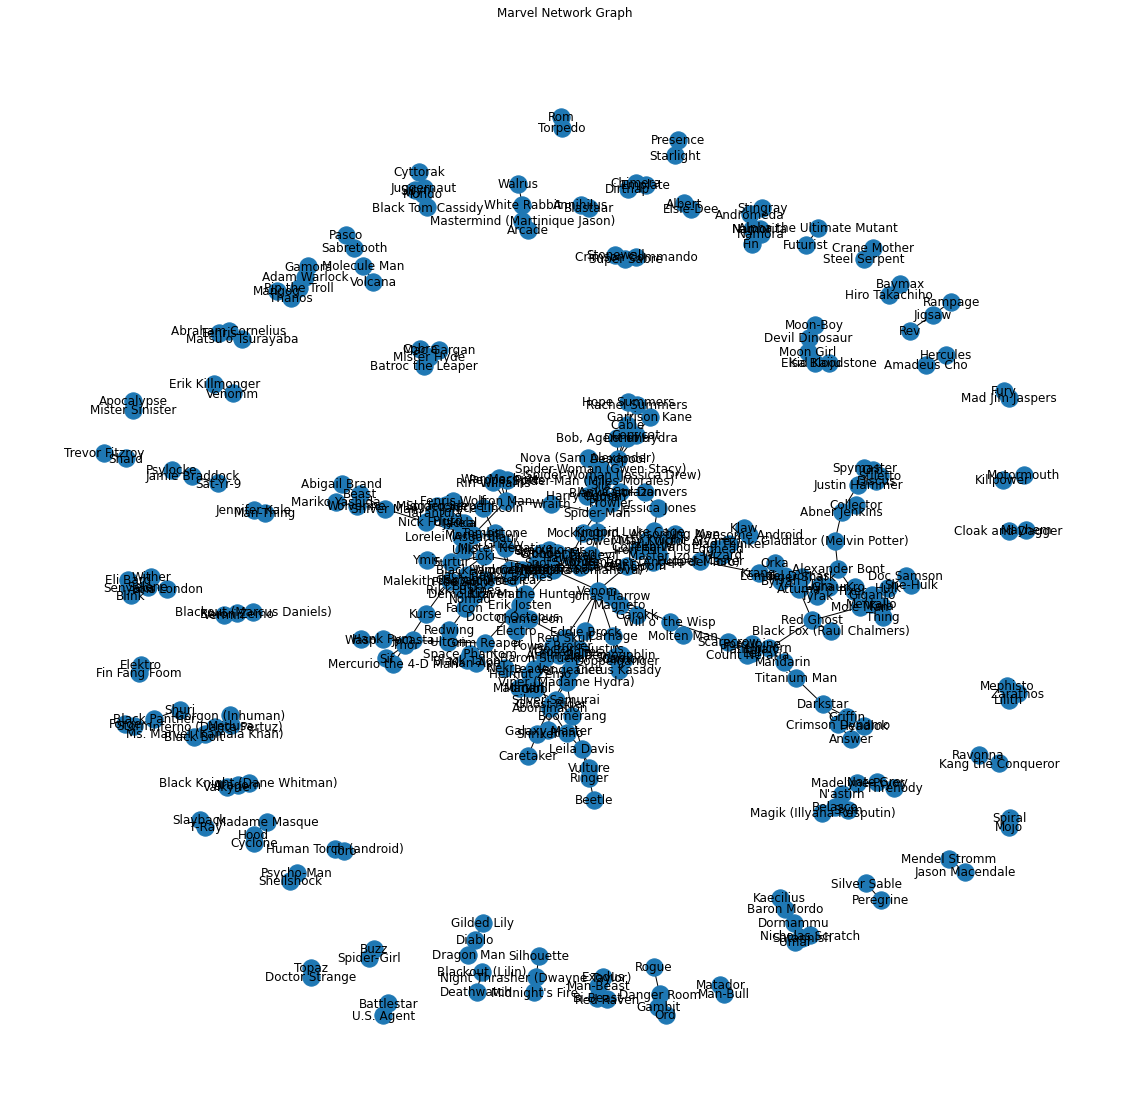

In [41]:
# initialize empty graph object
full_network = nx.Graph()

# add nodes
full_network.add_nodes_from(nodes_new['id'])

# add edges
full_network.add_edges_from(edges.values.tolist())

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(full_network, seed = 11)
nx.draw_networkx(full_network, pos, with_labels=True)
plt.title("Marvel Network Graph")
plt.axis('off')
plt.show()

This is a little hard to read. However, we can see that there seems to be a main cluster in the middle and many partnerships that are disconnected from the main cluster. 

Let's add colors based on character `group` (i.e. hero, villain, antihero).

In [42]:
# initiate empty list
colors = []

# add color for each character based on group
for row in nodes_new.itertuples():
    if getattr(row, 'group') == 0: 
        colors.append('#86c5da')    # blue for heroes
    elif getattr(row, 'group') == 1: 
        colors.append('#d472bc')    # pink for villains
    else:
        colors.append('#8a72d4')    # purple for antiheroes

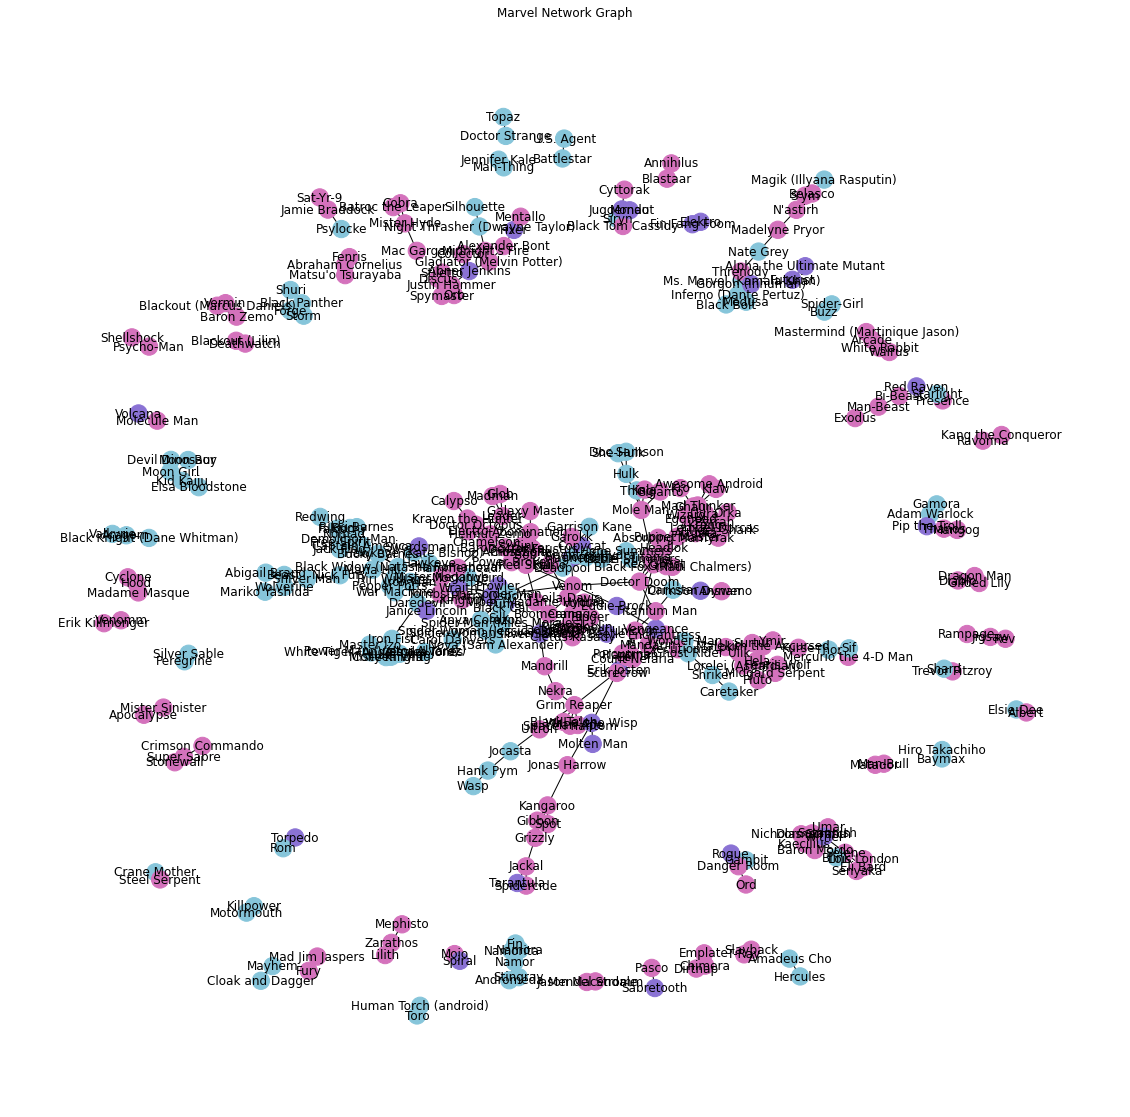

In [43]:
# plot with colors
plt.figure(figsize=(20, 20))
nx.draw_networkx(full_network, with_labels=True, node_color = colors)

plt.title("Marvel Network Graph")
plt.axis('off')
plt.show()

There seems to be a large cluster of villain partnetships and a sightly smaller cluster of hero partnerships. There are a number of hero-hero and villain-villain partnerships, but there are also hero-villain partnerships as well. 

***

### Centrality Measures

First, let's calculate degree centrality for each node using **NetworkX**'s `degree_centrality()` function.

In [44]:
degree = nx.degree_centrality(full_network)

Now let's calculate eingenvector centrality using **NetworkX**'s `eigenvector_centrality()` function.

In [45]:
eigen = nx.eigenvector_centrality(full_network)

Now let's combine these into a readable data frame.

In [46]:
combined = nodes_new

combined['degree_centrality'] = degree.values()
combined['eigenvector_centrality'] = eigen.values()

combined[['group', 'id', 'degree_centrality', 'eigenvector_centrality']].head(10)

,group,id,degree_centrality,eigenvector_centrality
0,1,Baron Zemo,0.005747,6.529247e-31
1,1,N'astirh,0.008621,1.038175e-19
2,0,Silver Sable,0.002874,1.884551e-37
3,0,Hope Summers,0.002874,1.361826e-03
4,0,Magik (Illyana Rasputin),0.002874,4.245237e-20
5,0,Night Thrasher (Dwayne Taylor),0.005747,6.529247e-31
6,1,Orb,0.002874,1.667104e-17
7,0,Forge,0.002874,2.362588e-28
8,0,U.S. Agent,0.002874,1.884551e-37
9,1,Venom,0.017241,1.224377e-01


What is the average centrality for each category?

In [47]:
nodes_new.groupby('group')[['degree_centrality', 'eigenvector_centrality']].mean()

,degree_centrality,eigenvector_centrality
group,,
0,0.005699,0.002663
1,0.005836,0.014349
2,0.004762,0.004068


Within the full network, heroes and villains have very similar degree centrality, with villain degree centrality being slighty higher than that of heroes. 

Villains have significantly higher eigenvector centrality than heroes. 

Let's add a size factor for each node based on their degree.

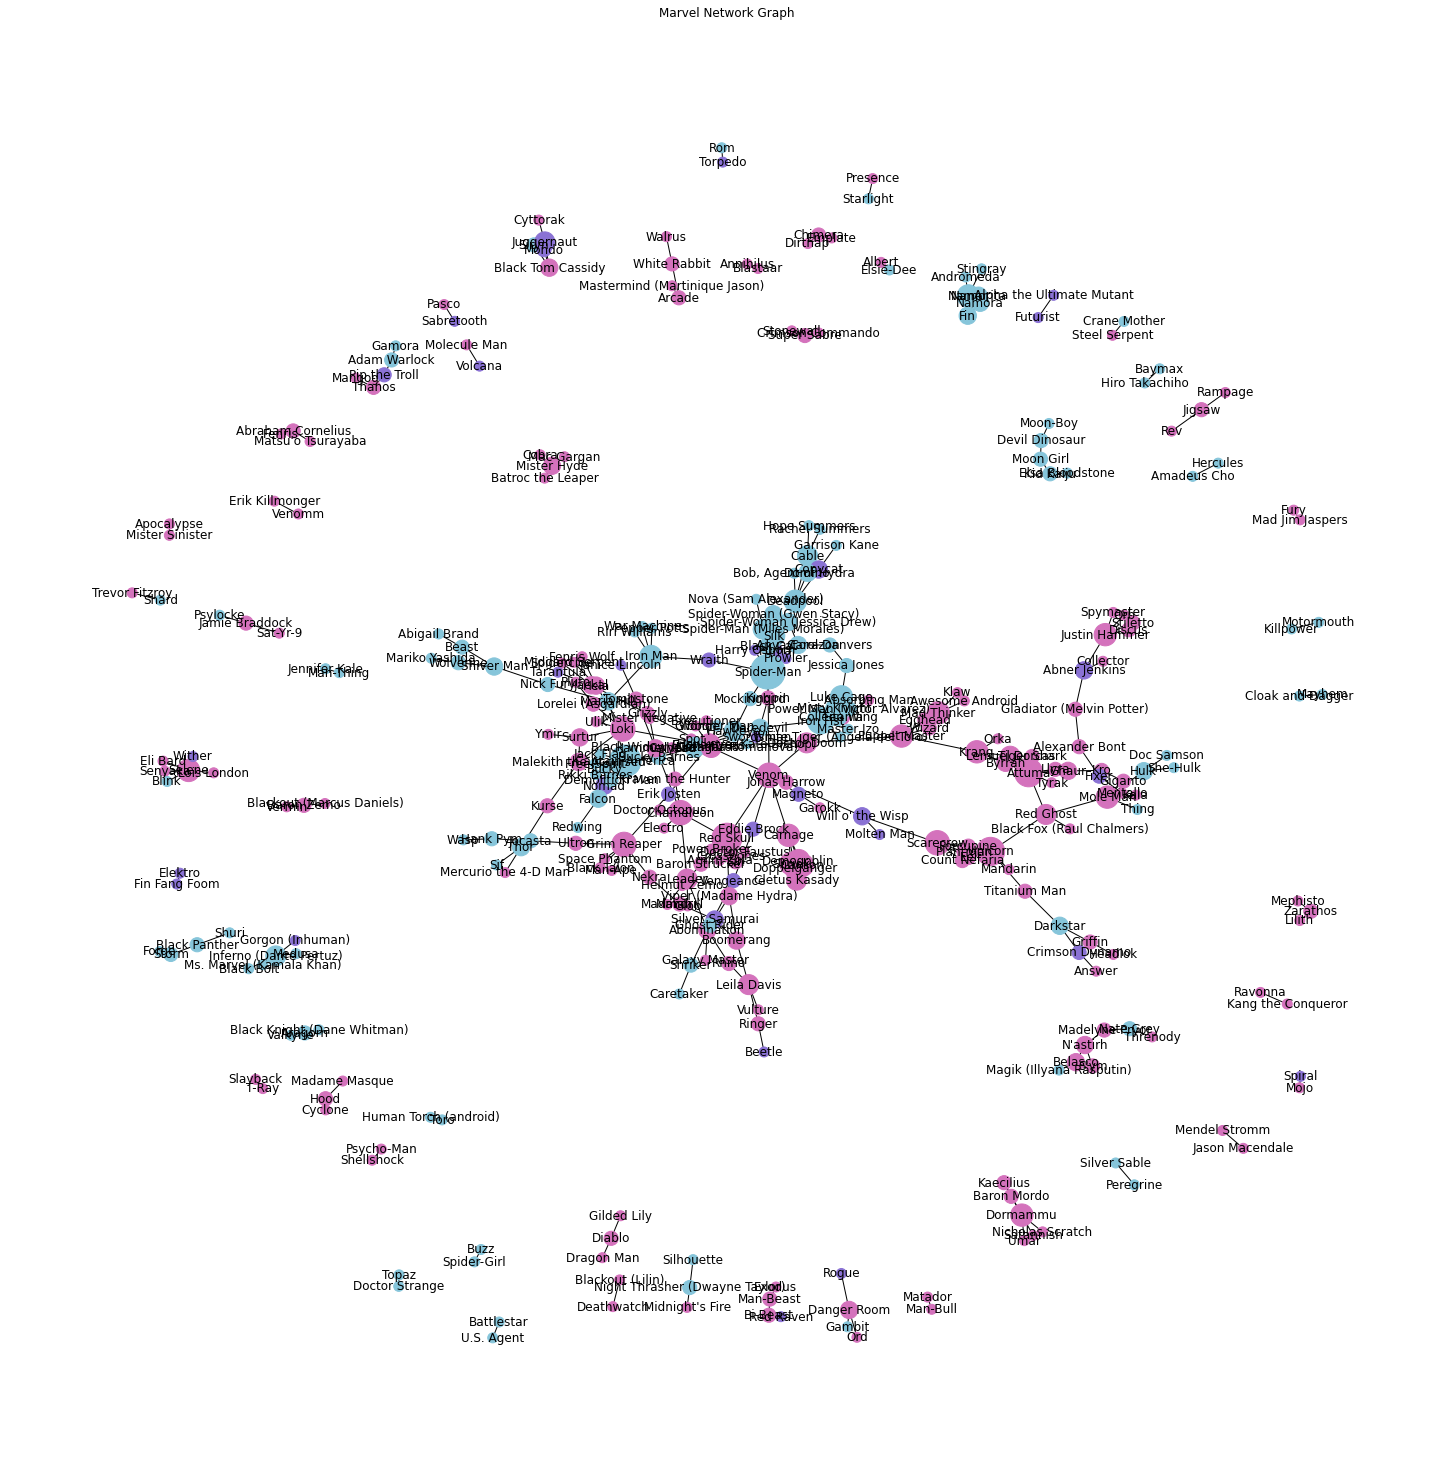

In [48]:
d = dict(nx.degree(full_network))

plt.figure(figsize=(20, 20))
nx.draw(full_network, pos, with_labels=True, node_color = colors, node_size = [v * 100 for v in d.values()])
plt.title("Marvel Network Graph")
plt.axis('off')
plt.show()

**Who are the characters with the highest degree centrality? (Higher than 0.015)**

In [49]:
degree_labels = {}

for key, value in degree.items():
    if value >= 0.015:
        degree_labels[key] = key

len(degree_labels)

11

There are 11 characters with degree centrality higher than 0.015.

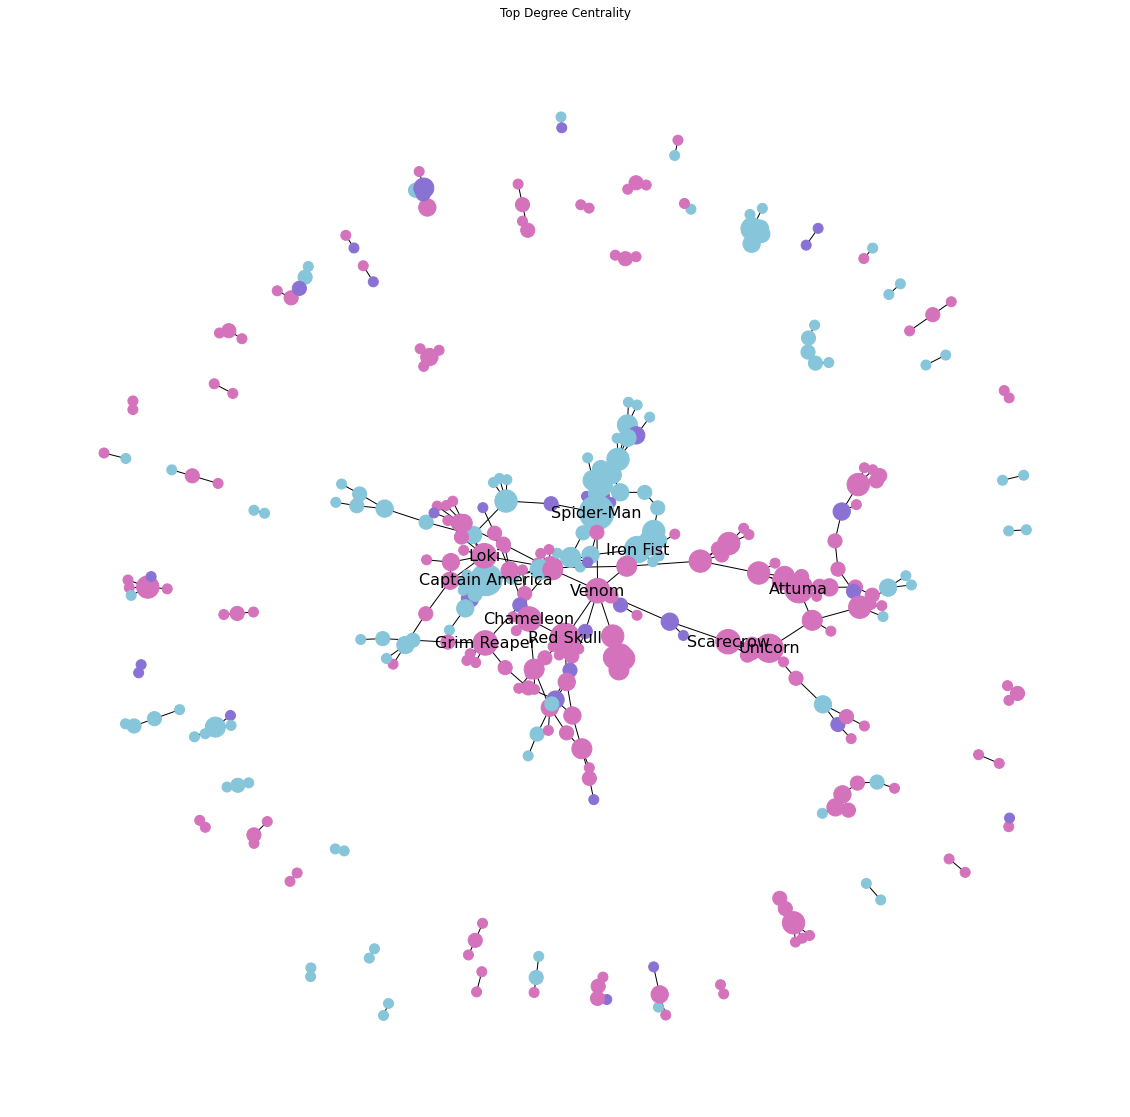

In [50]:
plt.figure(figsize=(20, 20))
nx.draw_networkx(full_network, pos, with_labels=False, node_color = colors, node_size = [v * 100 for v in d.values()])
nx.draw_networkx_labels(full_network, pos, labels = degree_labels, font_size = 16)
plt.title("Top Degree Centrality")
plt.axis('off')
plt.show()

Above are the top 11 characters based on degree centrality. Of those, 3 are heroes (Captain America, Spider-Man, Iron Fist) and 8 are villains (Loki, Venom, Attuma, Scarecrow, Unircorn, Grim Reaper, Red Skull, Chameleon). 

**Who are the characters with the highest eigenvector centrality? (Higher than 0.05)** 

In [51]:
eigen_labels = {}

for key, value in eigen.items():
    if value >= 0.05:
        eigen_labels[key] = key

len(eigen_labels)

8

There are 8 characters with eigenvector centrality greater than 0.05.

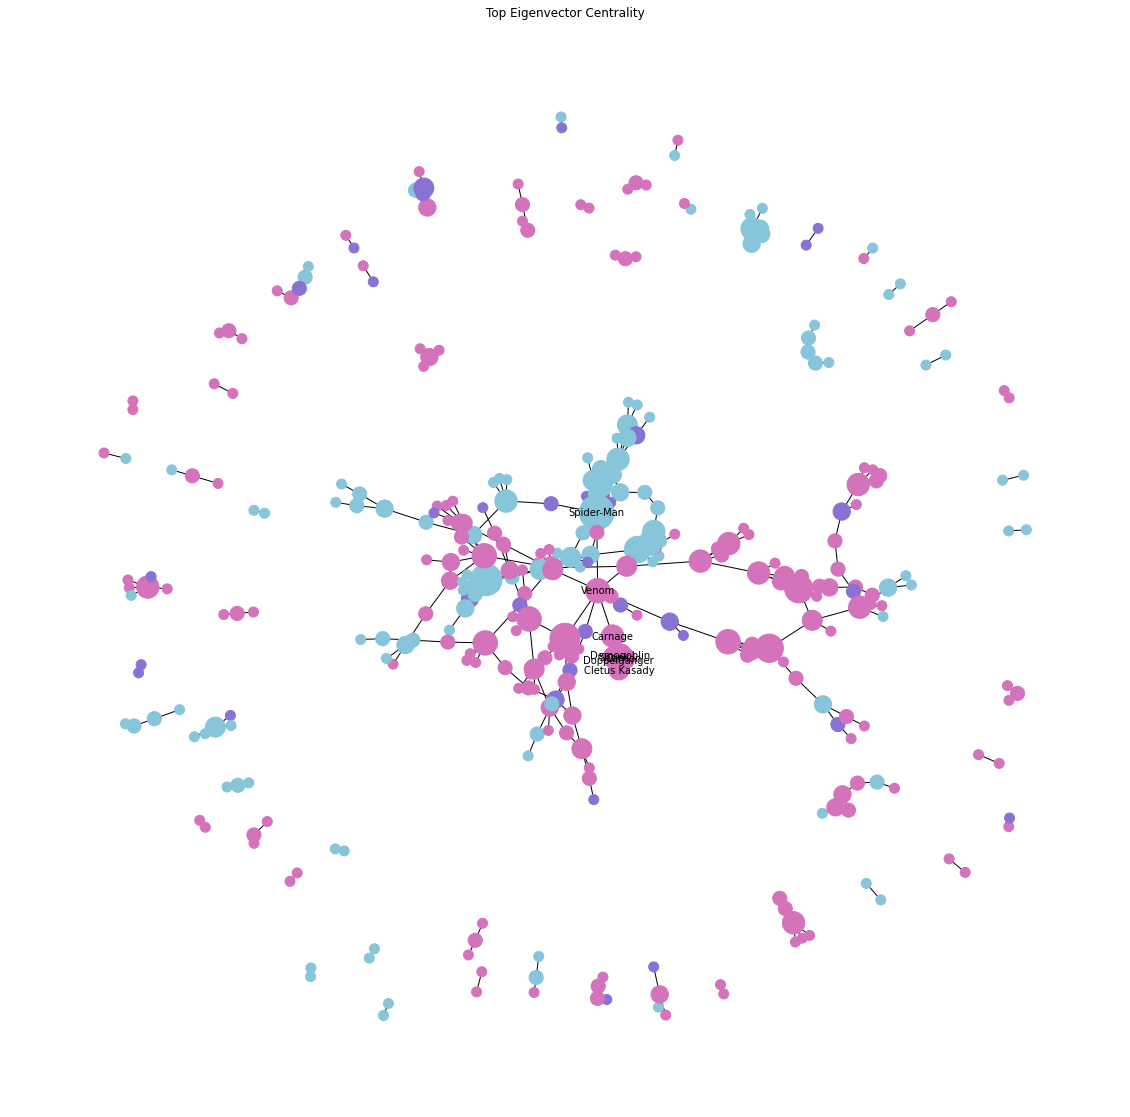

In [52]:
plt.figure(figsize=(20, 20))
nx.draw_networkx(full_network, pos, with_labels=False, node_color = colors, node_size = [v * 100 for v in d.values()])
nx.draw_networkx_labels(full_network, pos, labels = eigen_labels, font_size = 10)
plt.title("Top Eigenvector Centrality")
plt.axis('off')
plt.show()

Of the top 8 characters with the highest eigenvector centrality, only one (Spider-Man) is a hero. 

***

### Heroes vs. Villains

Let's split the dataset into separate dataframes for heroes and villains and calculate centrality for each group.

In [53]:
# heroes
heroes = nodes[nodes['group'] == 0]

heroes_partners = edges[edges['source'].isin(heroes['id'])]
heroes_partners = heroes_partners[heroes_partners['target'].isin(heroes['id'])]

heroes_partners.head(5)

,source,target
5,Silver Sable,Peregrine
6,Hope Summers,Cable
9,Night Thrasher (Dwayne Taylor),Silhouette
11,Forge,Storm
12,U.S. Agent,Battlestar


In [54]:
# villains
villains = nodes[nodes['group'] == 1]

villains_partners = edges[edges['source'].isin(villains['id'])]
villains_partners = villains_partners[villains_partners['target'].isin(villains['id'])]

villains_partners.head(5)

,source,target
0,Baron Zemo,Blackout (Marcus Daniels)
1,Baron Zemo,Vermin
2,N'astirh,S'ym
3,N'astirh,Belasco
4,N'astirh,Madelyne Pryor


Now let's make the networks.

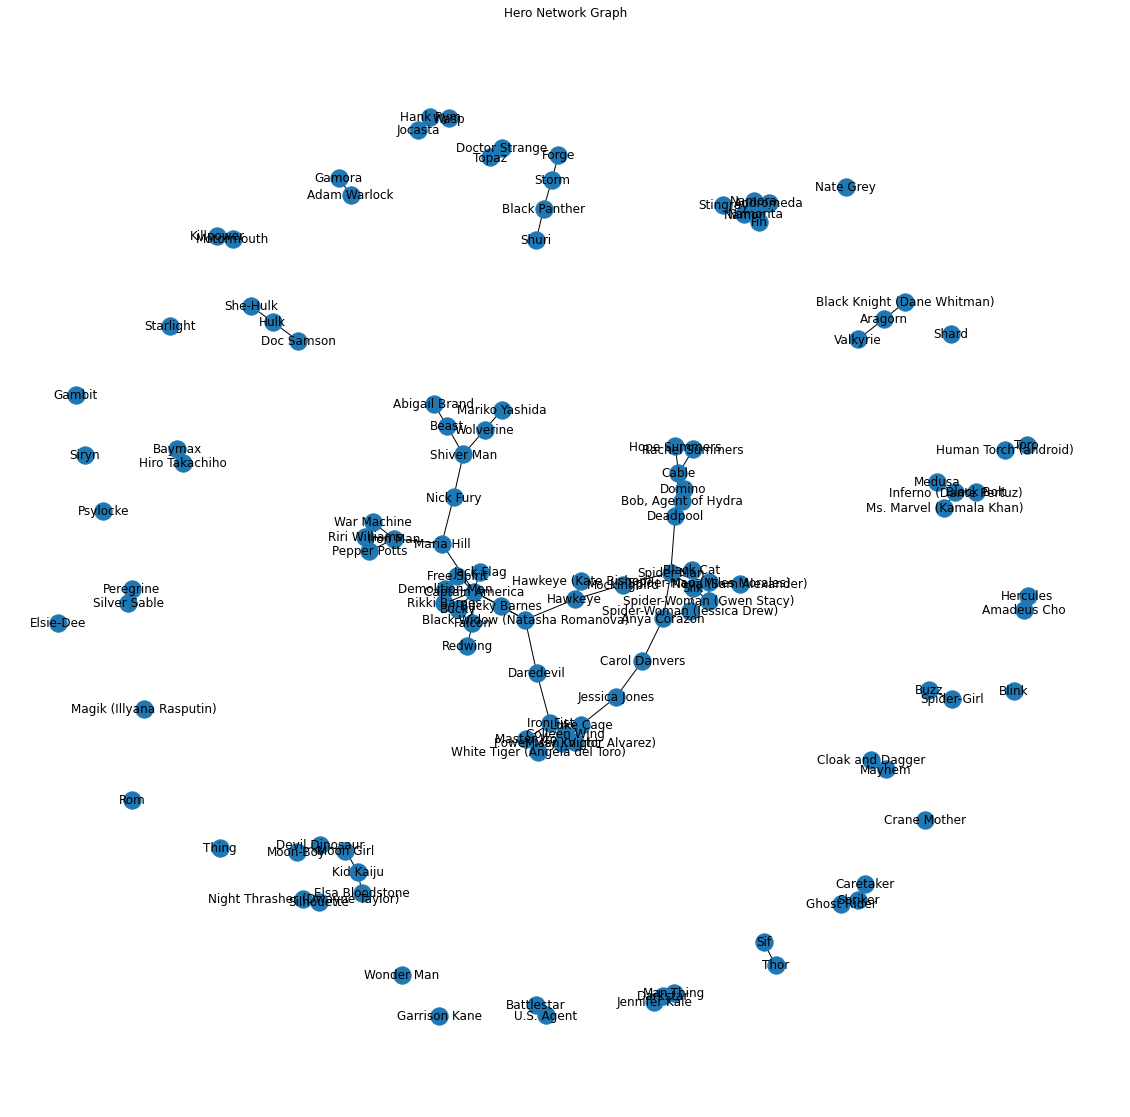

In [55]:
# initialize empty graph object
hero_network = nx.Graph()

# add nodes
hero_network.add_nodes_from(heroes['id'])

# add edges
hero_network.add_edges_from(heroes_partners.values.tolist())

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(hero_network, seed = 11)
nx.draw_networkx(hero_network, pos, with_labels=True)
plt.title("Hero Network Graph")
plt.axis('off')
plt.show()

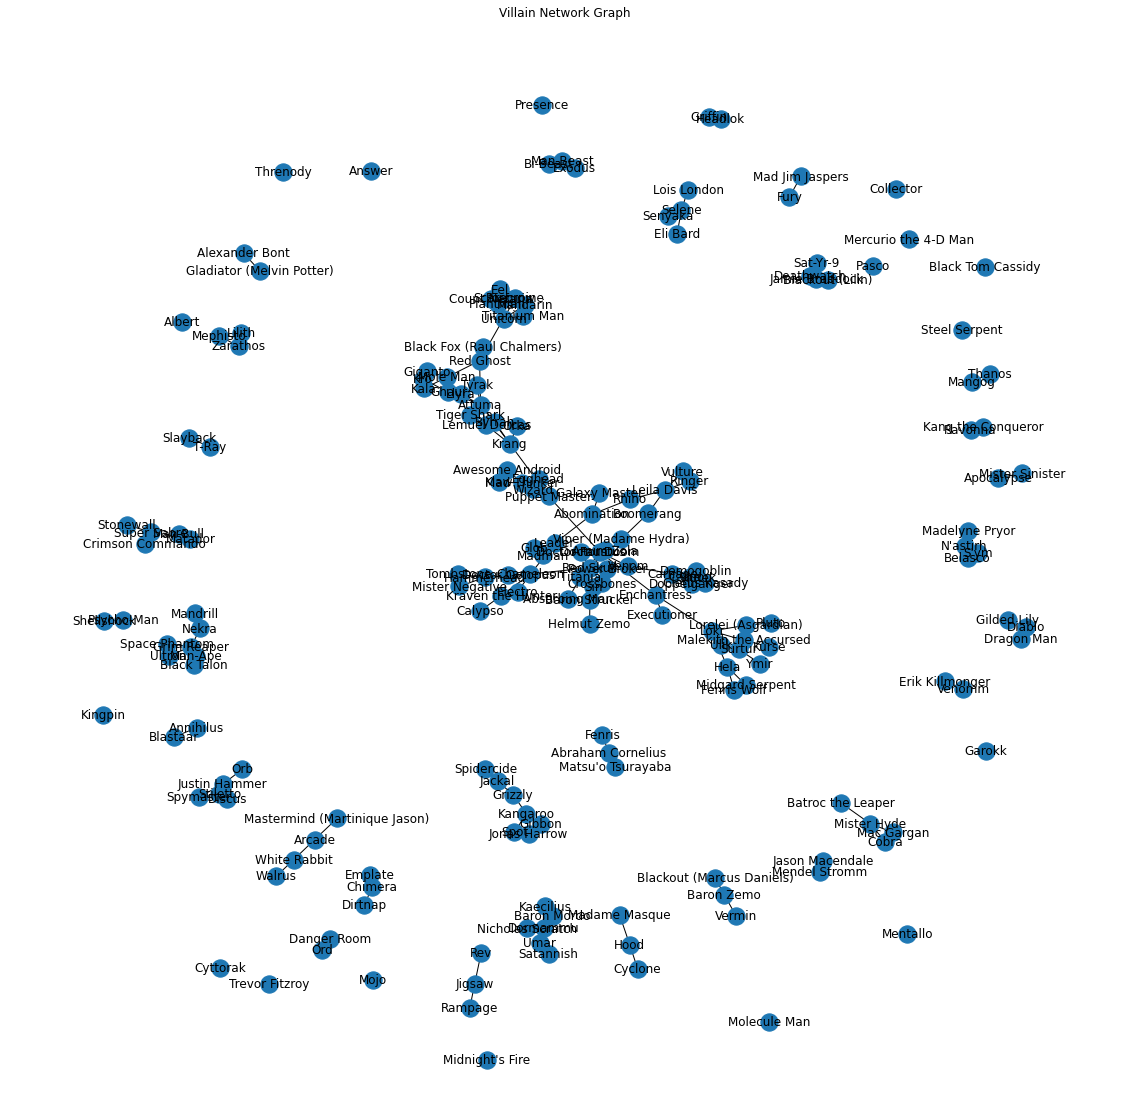

In [56]:
# initialize empty graph object
villain_network = nx.Graph()

# add nodes
villain_network.add_nodes_from(villains['id'])

# add edges
villain_network.add_edges_from(villains_partners.values.tolist())

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(villain_network, seed = 11)
nx.draw_networkx(villain_network, pos, with_labels=True)
plt.title("Villain Network Graph")
plt.axis('off')
plt.show()

Now let's calculate centrality for both sets.

In [57]:
heroes_degree = nx.degree_centrality(hero_network)

hero = heroes_degree.keys()
hero_degree = heroes_degree.values()

heroes_degree = pd.DataFrame()

heroes_degree['hero'] = hero
heroes_degree['degree_centrality'] = hero_degree

heroes_degree


,hero,degree_centrality
0,Silver Sable,0.008403
1,Hope Summers,0.008403
2,Magik (Illyana Rasputin),0.000000
3,Night Thrasher (Dwayne Taylor),0.008403
4,Forge,0.008403
...,...,...
115,White Tiger (Angela del Toro),0.008403
116,Carol Danvers,0.016807
117,Peregrine,0.008403
118,Namora,0.025210


In [58]:
villains_degree = nx.degree_centrality(villain_network)

villain = villains_degree.keys()
villain_degree = villains_degree.values()

villains_degree = pd.DataFrame()

villains_degree['villain'] = villain
villains_degree['degree_centrality'] = villain_degree

villains_degree

,villain,degree_centrality
0,Baron Zemo,0.010363
1,N'astirh,0.015544
2,Orb,0.005181
3,Venom,0.015544
4,Selene,0.015544
...,...,...
189,Belasco,0.010363
190,Dragon Man,0.005181
191,Bi-Beast,0.005181
192,Alexander Bont,0.005181


In [59]:
heroes_degree['degree_centrality'].mean()

0.013725490196078417

In [60]:
villains_degree['degree_centrality'].mean()

0.009134127450456721

While in the full network heroes and villains had similar degree centrality, when filtered for only hero-hero or villain-villain partnerships, heroes have a significanty higher average degree centrality. 